In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# grAdapt
import grAdapt
from grAdapt.models import Sequential
from grAdapt.space.datatype import Integer, Float, Categorical

## 1. Introduction
This is a brief tutorial on how to tune hyperparameters of k-nearest neighbors (KNN) with **grAdapt**. KNN takes up one integer hyperparameter.

### 1.1 Data Set
For the data set, we will use the **NIST data set** as it is small enough to train a classifier fast on it. Though the nature of the developed package is to optimize of float variables, we will take a look at integer optimization.

In [1]:
import os
plot_path = 'plots/'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

In [2]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

print(data.shape)

# Split data into train and validation subsets
X_train, X_val, y_train, y_val = train_test_split(
    data, digits.target, test_size=0.8, shuffle=False)

(1797, 64)


## 2. Define Blackbox

The intuition behind defining a blackbox function is to fit the classifier to the training set and then returning the validation accuracy. The validation accuracy is to be maximized and the input variables of the blackbox function are the hyperparameters. The hyperparameters are set when creating a classifier instance.

In [3]:
def knn_opt(n):
    # create KNN instance
    neigh = KNeighborsClassifier(n_neighbors=n)
    
    # fit/train
    neigh.fit(X_train, y_train)
    
    
    # return validation accuracy
    return neigh.score(X_val, y_val)

## 3. Hyperparameter Optimization with grAdapt

In this section, we are creating a **grAdapt Sequential** model. For brevity, settings of the Sequential model are not demonstrated. We will also take a look how to define search spaces by using **grAdapt Datatypes**.

KNN only requires one hyperparameter which is $k$.

In [4]:
# create base model
model = Sequential()

# create bounds
k_var = Integer(low=1, high=100)
bounds = [k_var]

In [5]:
res = model.maximize_args(knn_opt, bounds, 500, show_progressbar=True)

Sampling 75 random points.
Random function evaluations. This might take a while.


 15%|████████████▍                                                                    | 77/500 [00:00<00:36, 11.49it/s]

Finding optimum...


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:03<00:00,  7.89it/s]


In [6]:
y_knn = res['y']
x_knn = res['x']

In [7]:
x_knn_sol = res['x_sol']
y_knn_sol = res['y_sol']
print(x_knn_sol)
print(y_knn_sol)

[2.30049934]
0.913769123783032


### 3.1 Training Plot

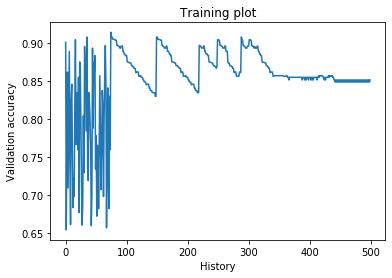

In [8]:
plt.plot(np.arange(y_knn.shape[0]), y_knn)
plt.title('Training plot')
plt.xlabel('History')
plt.ylabel('Validation accuracy')
plt.show()

### 3.2 Hyperparameter Plot of k

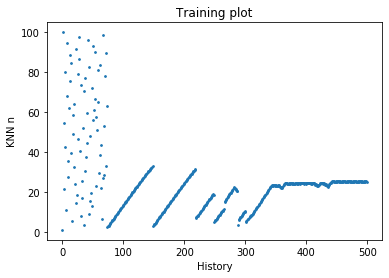

In [9]:
plt.scatter(np.arange(x_knn.shape[0]), x_knn, s=3)
plt.title('Training plot')
plt.xlabel('History')
plt.ylabel('KNN n')
plt.show()

### 3.3 Hyperparameter Space Plot

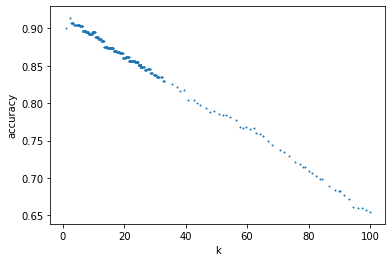

In [10]:
plt.scatter(x_knn, y_knn, s=1)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.show()

## 4. Results

A linear decrease of the accuracy is visible when $n$ is set higher. Regions where points led to poor performances were evaluated less. Good regions, on the other hand, are more dense with points. grAdapt still escapes from local optima. But the chances of obtaining higher values of $n$ is decreased, just not vanished (to ensure a global solution). It works just as expected. When tuning by hand, the user would also avoid higher $n$ and evaluate lower $n$ more often.